# Project Description

For this project, I am working on a data analysis that is looking into whether there is a relationship between park size and diversity in each park.

Research Question: Do larger parks have more diversity?

Background: I would assume that larger parks (based on acres) have more diversity, however I am interested to find out whether diversity could be more so related to location of natural parks rather than size. Diversity is being measured by the number of species that exist in the park regardless of the season. The csv files containing the park and species data is from https://www.kaggle.com/nationalparkservice/park-biodiversity/version/3?select=parks.csv

Hypothesis: How is park size correlated with the diversity in the park?

## Project Code

If it makes sense for your project, you can have code and outputs here in the notebook as well.

In [1]:
#Import Functions
from my_module.functions import clean_data, plot_feature, perform_regression

In [2]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

#### Reading in the csv files

In [3]:
# test it out

#parks dataframe contains information on the national parks in the United States. Main information
#contained that we want is on the size of each park (in acres)
parks = pd.read_csv('parks.csv')
parks.head()

,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


In [4]:
species = pd.read_csv('species.csv')
species.head()

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,NaN
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,NaN
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,NaN
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,NaN
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,NaN


#### Get the number of sepcies in each park

In [5]:
#df.groupby(col).count() counts number of occurrences of each unique element from specified column (col) in dataframe (df)
#will return the same values in every row, so can just call any column to get number of species in each park
num_species = species.groupby("Park Name").count().get("Category").to_frame()
num_species.head()

,Category
Park Name,
Acadia National Park,1709
Arches National Park,1048
Badlands National Park,1389
Big Bend National Park,2269
Biscayne National Park,1726


#### Merge num_species to parks dataframe (so all data needed is together)

In [6]:
#will merge to each row in parks the appropriate number of species in that park
parks_div = pd.merge(parks, num_species, left_on = 'Park Name', right_index = True)
parks_div.rename(columns = {"Category": "num_species"}, inplace = True)
parks_div.head()

,Park Code,Park Name,State,Acres,Latitude,Longitude,num_species
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21,1709
1,ARCH,Arches National Park,UT,76519,38.68,-109.57,1048
2,BADL,Badlands National Park,SD,242756,43.75,-102.50,1389
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25,2269
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08,1726


#### Cleaning parks_div

In [7]:
#drop any of the rows with missing columns, and only return the Park Name, Acres, and num_species columns

get_cols = ['Park Name', 'Acres', 'num_species']
parks_div = clean_data(parks_div, get_cols)
parks_div.shape

(56, 3)

In [8]:
#Need to check if we need to convert the types of any of the data contained in our features
#so that they can be used for analysis

# We notice that the Park Name column contains only string elements, Acres is an int, 
# and num_species is also an int which is good 

parks_div = parks_div[['Park Name', 'Acres', 'num_species']]
parks_div.dtypes

Park Name      object
Acres           int64
num_species     int64
dtype: object

#### Plots features

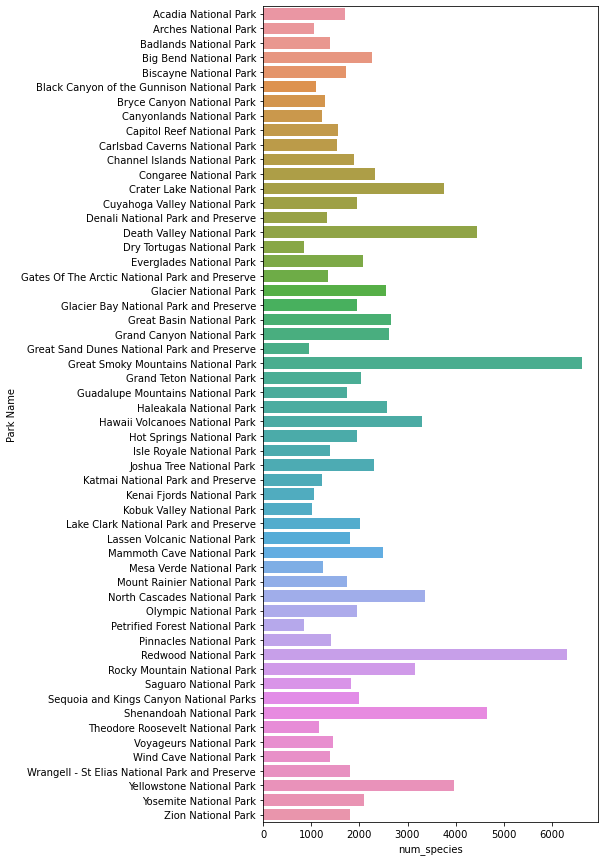

In [9]:
#Barplot of number of species in each park
fig0, ax = plt.subplots(figsize = (6, 15))
sns.barplot(x = 'num_species', y = 'Park Name', data = parks_div)
fig0 = plt.gcf()

<AxesSubplot:xlabel='num_species', ylabel='Count'>

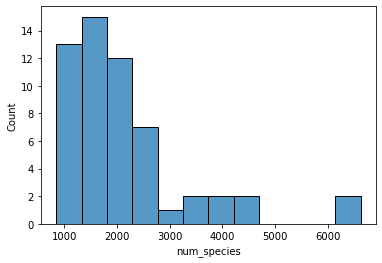

In [10]:
#Frequency distribution of number of species in national parks
fig1 = plot_feature('histogram', 'num_species', parks_div)
fig1

<AxesSubplot:xlabel='Acres', ylabel='Count'>

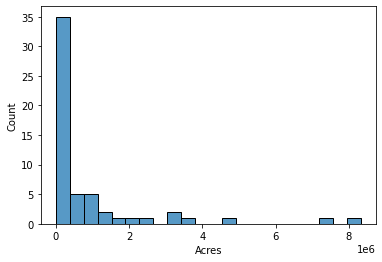

In [11]:
#Frequency distribution of size (in acres) of national parks
fig2 = plot_feature('histogram', 'Acres', parks_div)
fig2

<AxesSubplot:xlabel='Acres', ylabel='num_species'>

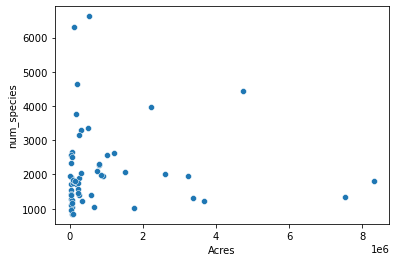

In [12]:
#Scatterplot between the size (in acres) and number of species in each national park
fig3 = plot_feature('scatterplot', 'Acres', parks_div, 'num_species')
fig3

#### Analysis

The histograms indicate that each of the features are not normalized. Each of the histograms for the features of Acres and for num_species both are skewed to the right. This notion acts as an indicator that using the median may be a better measure of central tendency. From the scatterplot between the features Acres and num_species, you can also notice that there is no linear relationshp between those two features

#### More tests to reaffirm conclusion

In [13]:
#Linear regression
avg_species = parks_div['num_species'].median()
avg_acres = parks_div['Acres'].median()

t_val, p_val = ttest_ind(avg_acres, avg_species)

#If the p-value is less than significance level (in this case 0.01), will reject the null 
# (that there is a relationship between size and number of species)

if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is NOT a significant difference!


/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
#Linear Model
res = perform_regression(parks_div, 'Acres', 'num_species')

In [15]:
#output regression summary
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Acres   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                  0.001011
Date:                Wed, 01 Dec 2021   Prob (F-statistic):              0.975
Time:                        11:22:02   Log-Likelihood:                -882.64
No. Observations:                  56   AIC:                             1769.
Df Residuals:                      54   BIC:                             1773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.148e+05   4.72e+05      1.939      

#### Analysis
Analyzing this plot, we see that there is no relationship between the size of the natural park and the number of species that exist in that park. This conclusion can be asserted because the r indicates the correlation between two variables and if we calculate what the correlation coefficient r is based on the given value from the report R-squared, we see that there it is equal to 0. As such, we can assert that there is no relationship between Acres and num_species

#### Test functions

In [16]:
#run test functions
!pytest my_module/test_functions.py

============================= test session starts ==============================
platform linux -- Python 3.9.5, pytest-6.2.5, py-1.10.0, pluggy-1.0.0
rootdir: /home/sskrishn/Project_COGS18_FA21
plugins: anyio-3.2.1
collected 3 items                                                              

my_module/test_functions.py ...                                          [100%]

=============================== warnings summary ===============================
../../../opt/conda/lib/python3.9/site-packages/patsy/constraint.py:13
  /opt/conda/lib/python3.9/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
    from collections import Mapping

-- Docs: https://docs.pytest.org/en/stable/warnings.html
========================= 3 passed, 1 warning in 1.67s =========================


#### Extra Credit (*optional*)

Replace all of this text with a brief explanation (~3 sentences) of: 
1. Your Python Background

I had limited experience with python before starting this course, however I do have experience in other programmign languages such as MATLAB, so I was able to correlate some of the concepts I learned from MATLAB into this course.

2. How your project went above and beyond the requirements of the project and/or how you challenged yourself to learn something new with the final project

I think for this project, I had to learn the documentation on how to perform other kinds of manipulations I could make to a dataframe in order to filter and to get the data ready for analysis. Moreover, in order to enhance the scope of my project a bit, I had tried to incorporate methods for performing an analysis, such as a regression model, that wasn't included int he scope of this course, in order to further analyze whether the two variables that I wanted to assess were correlated or not.